In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import zscore

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import chi2, SelectKBest, SelectFromModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

plt.rcParams.update({'figure.figsize': (16, 6)})

Читаем данные из файла.
Удаляем строки с отсутствующими данными.
Для количественных признаков считаем выбросом отклонение от выборочного среднего больше чем на три сигмы. 

In [2]:
df = pd.read_csv('./data/raw/flights.csv')

df = df.drop(columns=['Unnamed: 9'])
df = df.dropna()

for column in ['DEP_DELAY', 'DISTANCE']:
    df = df[np.abs(zscore(df[column], axis=0)) < 3]
    
df = df.sample(n=10_000)

In [3]:
df.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DELAY,CANCELLED,DIVERTED,DISTANCE
count,10000.0000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,15.3628,3.82650,1313.948100,2.188900,0.000400,0.001500,727.227200
std,8.6676,1.96992,468.191319,14.266414,0.019997,0.038703,513.919374
min,1.0000,1.00000,5.000000,-24.000000,0.000000,0.000000,31.000000
25%,8.0000,2.00000,922.000000,-5.000000,0.000000,0.000000,340.000000
50%,15.0000,4.00000,1309.000000,-2.000000,0.000000,0.000000,591.000000
75%,23.0000,5.00000,1716.000000,3.000000,0.000000,0.000000,972.000000
max,30.0000,7.00000,2400.000000,87.000000,1.000000,1.000000,2466.000000


День недели и время суток признаки не порядковые, преобразуем их с ohe-hot.
Пока не исключаем первый бинарный признак, он понадобится для группировки в дальнейшем.

In [4]:
for i, day in enumerate(['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THIRSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']):
    df[day] = (df['DAY_OF_WEEK'] == i + 1).astype('int32')

df['MORNING'] = (df['DEP_TIME'].between(500, 1200)).astype('int32')
df['DAY'] = (df['DEP_TIME'].between(1200, 1600)).astype('int32')
df['EVENING'] = (df['DEP_TIME'].between(1600, 2200)).astype('int32')
df['NIGHT'] = (df['DEP_TIME'].between(2200, 2400) | df['DEP_TIME'].between(0, 500)).astype('int32')

df = df.drop(columns=['DAY_OF_WEEK', 'DEP_TIME'])

Проверим значимость признаков.
Для начала строим корреляционную матрицу.
Можно заметить, что дни недели, отмена полета и смена курса почти не коррелируют с задержкой вылета.

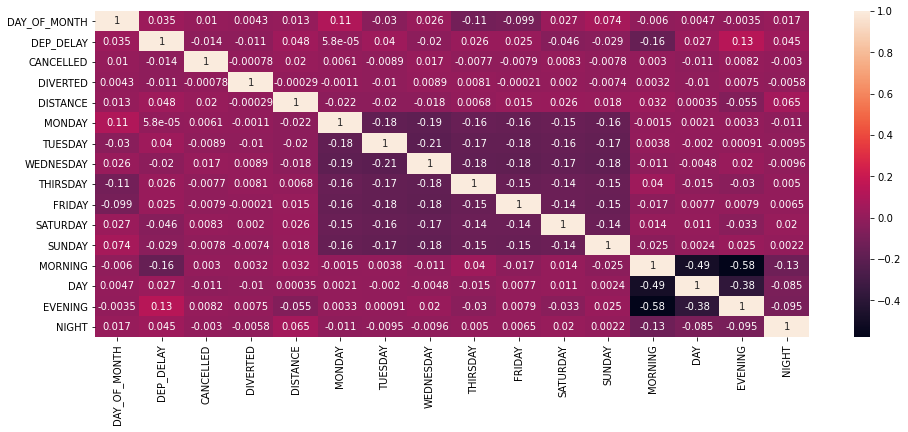

In [5]:
sns.heatmap(df.corr(), annot=True)

Далее вычисляем feature importance для признаков, используя random forest.
Используем 50 решающих деревьев.

In [6]:
# Should not exceed ~50k
df_reduced = df.sample(n=10_000)

y = df_reduced[['DEP_DELAY']]
X = df_reduced.drop(columns=['DEP_DELAY', 'OP_UNIQUE_CARRIER', 'ORIGIN'])

estimator = ExtraTreesClassifier(n_estimators=50)
estimator = estimator.fit(X, y.values.ravel())

Наибольшая значимость наблюдается у признака расстояния, следом у дня месяца.

In [7]:
importances = pd.DataFrame({
    'feature': [f for f in df_reduced.columns if f not in ['DEP_DELAY', 'OP_UNIQUE_CARRIER', 'ORIGIN']],
    'importance': estimator.feature_importances_
})

importances.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
feature,DAY_OF_MONTH,CANCELLED,DIVERTED,DISTANCE,MONDAY,TUESDAY,WEDNESDAY,THIRSDAY,FRIDAY,SATURDAY,SUNDAY,MORNING,DAY,EVENING,NIGHT
importance,0.048673,0.000442,0.001301,0.933376,0.001332,0.001489,0.001543,0.001444,0.001384,0.001365,0.001458,0.001549,0.001889,0.001558,0.001196


Опять замечаем, что по отдельности дни недели не влияют на target.
Заменим эти признаки на выходные/не выходные.
Также удалим cancelled и diverted, так как они снова не продемонстрировали своей значимости при прдсказании.

In [8]:
df = df.drop(columns=['CANCELLED', 'DIVERTED'])

df['WEEKDAY'] = df[['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THIRSDAY', 'FRIDAY']].any(axis='columns').astype('int32')
df['WEEKEND'] = df[['SATURDAY', 'SUNDAY']].any(axis='columns').astype('int32')

df = df.drop(columns=['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THIRSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY'])

Избавимся от линейной зависимости, удалим критерии weekend и morning.

In [9]:
df = df.drop(columns=['WEEKEND', 'MORNING'])

Оценим признаки.
Снова строим корреляционную матрицу.

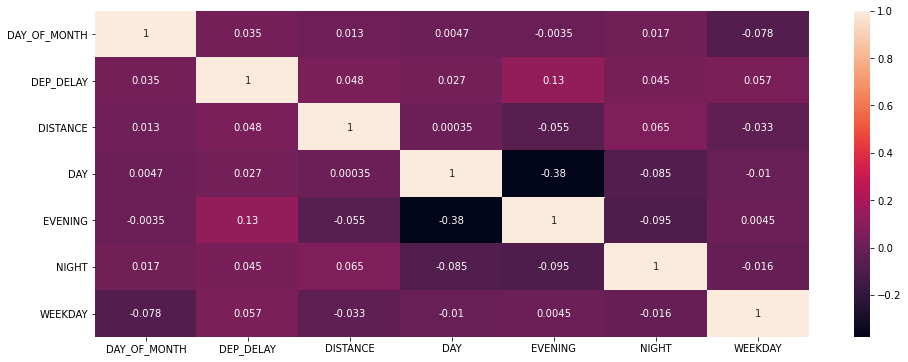

In [10]:
sns.heatmap(df.corr(), annot=True)

Тесты показывают, что квадрат детерминации в среднем в 1.8 раз выше при включении аэропортов и авиаперевозчиков.
Добавим признаки origin и carrier соответственно.
Используем one-hot encoding для преобразования категориальных признаков.

In [11]:
df = pd.get_dummies(df, prefix=['CARRIER'], columns=['OP_UNIQUE_CARRIER'], drop_first=True)
df = pd.get_dummies(df, prefix=['ORIGIN'], columns=['ORIGIN'], drop_first=True)

Для построения уравнения регрессии масштабируем данные.

In [12]:
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns]) 

Делим данные на тренировочные и тестовые в отношении 4 к 1.

In [13]:
y = df[['DEP_DELAY']]
X = df.drop(columns=['DEP_DELAY'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

Программма с SGD изначально читала матрицы из файла, не будем её переписывать.
Раскидаем финальные матрицы соответствующим по файлам.

In [14]:
np.savetxt('./data/train/X.csv', X=X_train, fmt='%.18f', delimiter=',')
np.savetxt('./data/train/y.csv', X=y_train, fmt='%.18f', delimiter=',')

np.savetxt('./data/test/X.csv', X=X_test, fmt='%.18f', delimiter=',')
np.savetxt('./data/test/y.csv', X=y_test, fmt='%.18f', delimiter=',')

Будем сравнивать работу нашей программы с работой SGD в scikit-learn.
Оттуда копировали интерфейс.

In [15]:
regression = SGDRegressor(early_stopping=True, verbose=1).fit(X_train, y_train)

/home/dikuchan/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-- Epoch 1
Norm: 0.11, NNZs: 267, Bias: 0.132809, T: 7200, Avg. loss: 0.007578
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.11, NNZs: 267, Bias: 0.149515, T: 14400, Avg. loss: 0.007211
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.11, NNZs: 267, Bias: 0.153010, T: 21600, Avg. loss: 0.007167
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.11, NNZs: 267, Bias: 0.157287, T: 28800, Avg. loss: 0.007141
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.12, NNZs: 267, Bias: 0.160089, T: 36000, Avg. loss: 0.007127
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 267, Bias: 0.161523, T: 43200, Avg. loss: 0.007117
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 0.12, NNZs: 267, Bias: 0.164363, T: 50400, Avg. loss: 0.007112
Total training time: 0.07 seconds.
-- Epoch 8
Norm: 0.12, NNZs: 267, Bias: 0.164160, T: 57600, Avg. loss: 0.007105
Total training time: 0.08 seconds.
-- Epoch 9
Norm: 0.13, NNZs: 267, Bias: 0.164597, T: 64800, Avg. loss: 0.007094
T

In [16]:
print(f'R2 Score: {regression.score(X_train, y_train)}')

R2 Score: 0.0604155834730391


In [17]:
print(f'Weights with Scikit SGD: {regression.intercept_}, {regression.coef_[:15]}')

Weights with Scikit SGD: [0.17016433], [ 0.01933817  0.03901354  0.03068567  0.04917769  0.05771338  0.01791465
 -0.00723318  0.00212925  0.01966439 -0.00974096  0.0119943   0.00742017
 -0.01696106  0.00114882  0.00937335]


К сожалению, вывод при verbose=1 не отображается непосредственно в ноутбуке.

In [18]:
from regression import Regressor

regression = Regressor(method='sgd', alpha=0.0001, tolerance=0.001, eta=0.01, stumble=2)
n = len(df.columns)
weights = regression.fit(n=n)

print(f'Weights with bare SGD: {np.array(weights)[:15]}')

Weights with bare SGD: [ 0.15778421  0.02657859  0.04449731  0.02948661  0.04728755  0.03231443
  0.02026888 -0.00209061  0.00228982  0.02093338 -0.00418166  0.01653059
  0.00360863 -0.01093955  0.00191344]


Рассмотрим коэффициенты при выделенные выше признаках.

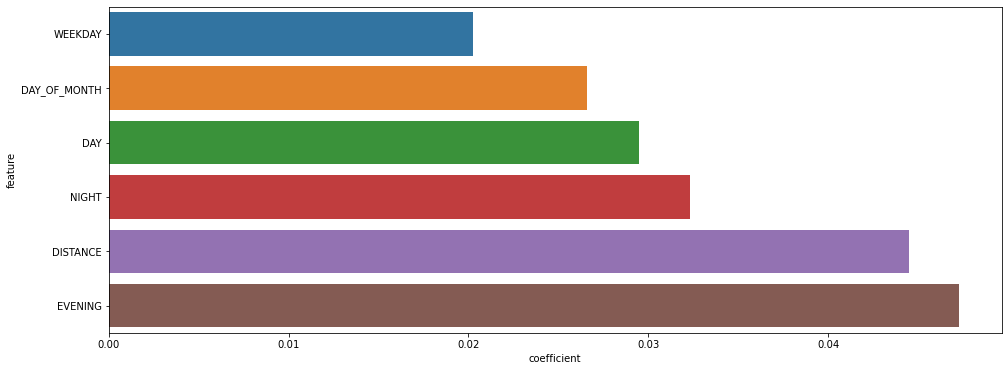

In [19]:
coefficients = pd.DataFrame({
    'feature': [''] + [f for f in df.columns if f != 'DEP_DELAY'][:6],
    'coefficient': weights[:7]
})

sns.barplot(x='coefficient', y='feature', data=coefficients[1:].sort_values(by=['coefficient']))

Отдельно выделим коэффициенты при признаках origin и carrier.
Рассмотрим, какие аэропорты и авиаперевозчики отличились.

In [20]:
residual_coefficients = pd.DataFrame({
    'feature': [f for f in df.columns if f != 'DEP_DELAY'][6:],
    'coefficient': weights[7:]
}).sort_values(by=['coefficient'])

origin_coefficients = residual_coefficients[residual_coefficients['feature'].str.startswith('ORIGIN')]
carrier_coefficients = residual_coefficients[residual_coefficients['feature'].str.startswith('CARRIER')]

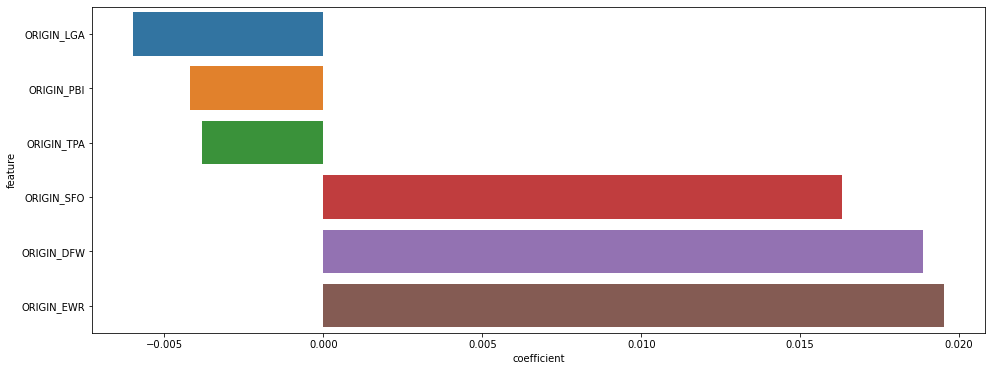

In [21]:
o = origin_coefficients.sort_values(by=['coefficient'])
data = pd.concat([o.head(3), o.tail(3)])

sns.barplot(x='coefficient', y='feature', data=data)

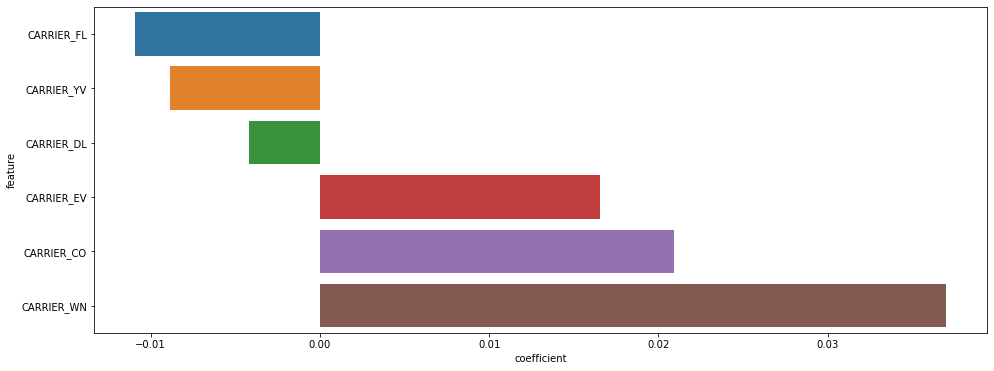

In [22]:
c = carrier_coefficients.sort_values(by=['coefficient'])
data = pd.concat([c.head(3), c.tail(3)])

sns.barplot(x='coefficient', y='feature', data=data)